# PSK-Modulation

## Abbildung des Bitstrom auf Datensymbole

Im Folgenden wird die Modulation eines binären Datenstrom per $M$-PSK demonstriert. Zunächst wird der binäre Datenstrom $u[k]$ auf die zeit- und wertediskreten Symbole $d[i]$ abgebildet. Diese sind bei einer PSK komplexwertig, wobei Real- und Imaginärteil nicht unabhängig voneinander sind, da die Information in der Symbolphase steckt. Bei der Abbildung wird eine Gray-Codierung verwendet.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ECCpath = '../ECCpython'
if (not ECCpath==None) and (not ECCpath in sys.path):
    sys.path.append(ECCpath)

from Modulation.modulation import Modulation

# cardinality of modulation scheme
M = 16
# number of bits per PSK symbol
m = int(np.round(np.log2(M)))
# Startphase der PSK
phi_0 = 0.0  # np.pi/M

# PSK alphabet 
idx = np.arange(M)
psk = np.cos(2*np.pi*idx/M+phi_0) + 1j*np.sin(2*np.pi*idx/M+phi_0)
#psk = np.reshape(psk,(M,1)).flatten()


# generate gray mapping
u_bin = [int2bin(u,m) for u in idx]
u_gray_bin = [bin2gray(u.tolist()) for u in u_bin]
gray_code = [bin2int(u) for u in u_gray_bin]
# gray_code is a vector with integer numbers which can be used as indexes 
# for the PSK symbols of inphase and quadrature components

In [3]:
# number of information bits
N_info_bits = 256
N_symbols = int(N_info_bits / m)
time_symbol = np.arange(N_symbols)

# generate information bits u[k]
info_bits = np.random.randint(0,2,N_info_bits)

# extract tuples of m bits
u_bin = np.reshape(info_bits,(N_symbols,m))
u_decgray = np.zeros((N_symbols,m))
d_psk = np.zeros(N_symbols,dtype=complex)

for run in np.arange(N_symbols):
    # mapping of bit tuples on decimal numbers (separated for real and imaginary parts)
    u_dec = bin2int(u_bin[run,:].tolist())
    # mapping index to Gray coded index to PSK symbols
    d_psk[run] = psk[gray_code[int(u_dec)]]
    

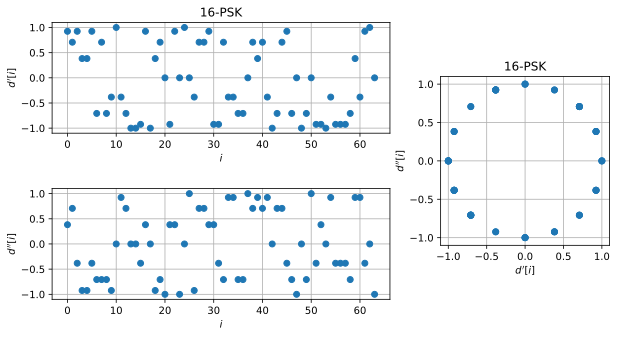

In [4]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10,5))
spec = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])
subspec = spec[0].subgridspec(2, 1)
plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(subspec[0])
ax1.plot(time_symbol, np.real(d_psk), marker='o',linestyle='none')
plt.xlabel('$i$')
plt.ylabel('$d^\prime[i]$')
#plt.yticks(sqrt_ask)
plt.title('%g-PSK' %(M))
plt.grid(True)

ax2 = fig.add_subplot(subspec[1])
ax2.plot(time_symbol, np.imag(d_psk), marker='o',linestyle='none')
plt.xlabel('$i$')
#plt.yticks(sqrt_ask)
plt.ylabel('$d^{\prime\prime}[i]$')
plt.grid(True)

ax3 = fig.add_subplot(spec[1])
ax3.plot(np.real(d_psk), np.imag(d_psk), marker='o',linestyle='none')
ax3.set(adjustable='box', aspect='equal')
plt.xlabel('$d^\prime[i]$')
plt.ylabel('$d^{\prime\prime}[i]$')
#plt.xticks(sqrt_ask)
#plt.yticks(sqrt_ask)
plt.title('%g-PSK' %(M))
plt.grid(True)

## Sendefilter 

Die Datensymbolfolge $d[k]$ muss nun in ein analoges, d.h. zeit- und Wertekontinuierliches Signal $x(t)$ überführt werden. Dazu dient das Sendefilter, mit dessen Impulsantwort $g_S(t)$ die Datenfolge zu falten ist. Wir erhalten das analoge Signal

\begin{equation}
    x(t) = T_s d[i] \ast g_S(t) = T_s \sum_i d[i] \cdot g_s(t-iT_s) \; .
\end{equation}

Zusammen mit dem Empfangsfilter $g_E(t)$ ist die 1. Nyquist-Bedingung 

\begin{equation}
    g(t) = g_E(t) \ast g_S(t)
    \qquad \text{mit} \qquad
    T_s \cdot g(i T_s) = 
    \begin{cases}
        1 & \text{für } i = 0 \\
        0 & \text{für } i \neq 0 
    \end{cases}
\end{equation}

zu erfüllen. Wichtig ist, dass die Gesamtimpulsantwort $g(t)$ die 1. Nyquist-Bedingung erfüllen muss, nicht aber die Impulsantworten von Sende- oder Empfangsfilter. Neben dem idealen Tiefpass mit si-förmiger Impulsantwort erfüllen auch alle Filter, deren Impulsantwort aus einer Fensterung des idealen Tiefpasses hervorgehen, die 1. Nyquist-Bedingung. In der Praxis werden häufig Wurzel-Kosinus-Rolloff-Filter mit der Impulsantwort

\begin{equation}
    g_{\mathrm{RRC}}(t) = \frac{4 r \frac{t}{T_S} \cos \left(\pi (1+r) \frac{t}{T_S} \right) + \sin \left( \pi (1-r) \frac{t}{T_S} \right)}{\left( 1- \left(4r \frac{t}{T_S} \right)^2 \right) \pi t}
\end{equation}

dem Roll-Off-Faktor $r$ und der Nyquist-Kreisfrequenz $\omega_{\mathrm{N}}=\frac{\pi}{T_S}$ eingesetzt. Die Übertragungsfunktion lautet

\begin{equation}
    G_{\mathrm{RRC}}(j \omega) = 
    \begin{cases} 
        1 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1-r \\
        \cos \left( \frac{\pi}{4r} \left( \frac{|\omega|}{\omega_{\mathrm{N}}} - (1-r) \right) \right)
        & \text{für } 1 - r \leq \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1+r \\
        0 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \geq 1+r 
    \end{cases}
\end{equation}

Das Empfangsfilter als Matched-Filter ist ebenfalls ein Wurzelkosinus-Rolloff-Filter. Beide zusammen resultieren in einer Kosinus-Rolloff-Charakteristik mit der Gesamtimpulsantwort

\begin{equation}
    g_{\mathrm{RC}}(t) = \frac{1}{T_S} \cdot \frac{\sin(\pi t/Ts)}{\pi t/T_S} \cdot \frac{\cos(r \pi t/T_S)}{1-(2rt/T_S)^2}
\end{equation}

und der Übertragungsfunktion

\begin{equation}
    G_{\mathrm{RC}}(j \omega) = 
    \begin{cases} 
        1 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1-r \\
        \frac{1}{2} \cdot \left[ 1 + \cos \left( \frac{\pi}{2r} \left( \frac{|\omega|}{\omega_{\mathrm{N}}} - (1-r) \right) \right) \right]
        & \text{für } 1 - r \leq \frac{|\omega|}{\omega_{\mathrm{N}}} \leq 1+r \\
        0 & \text{für } \frac{|\omega|}{\omega_{\mathrm{N}}} \geq 1+r  \; .
    \end{cases}
\end{equation}

Die Verläufe von Kosinus- und Wurzel-Kosinus-Rolloff-Filtern im unteren Bild verdeutlichen, dass die 1. Nyquist-Bedingung nur für das Gesamtfilter mit der Impulsantwort $g(t)=g_{\mathrm{RC}}(t)$ erfüllt ist.


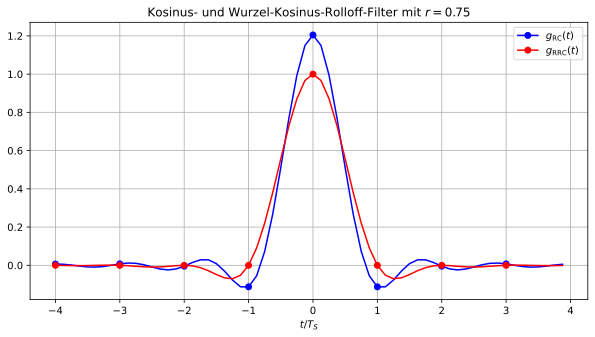

In [5]:
# roll-off factor of Root-Raised-Cosine filter
r = 0.75
# symbol duration in seconds
Ts = 1e-6
# oversampling factor
w = 8
# sampling rate in Hz
fa = w / Ts
# length of filter impulse response in samples
N_rc_sym = 8
# length of filter impulse response in samples
N_rc = N_rc_sym*w
tmp,g_rrc = rrcosfilter(N_rc,r,Ts,fa)
time,g_rc = rcosfilter(N_rc,r,Ts,fa)
time = time / Ts

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(time,g_rrc, 'b-o', markevery=(w), label='$g_{\mathrm{RC}}(t)$')
ax.plot(time,g_rc, 'r-o', markevery=(w), label='$g_{\mathrm{RRC}}(t)$')
plt.xlabel('$t/T_S$')
plt.title('Kosinus- und Wurzel-Kosinus-Rolloff-Filter mit $r=$%1.2f' %(r))
plt.grid(True)
plt.legend()


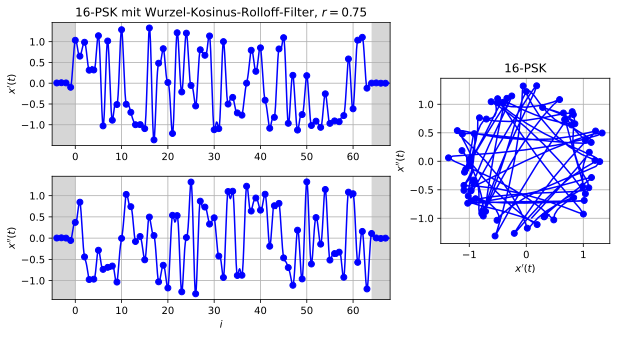

In [6]:
# oversampling data symbols by inserting w zeros 
x = np.append(np.reshape(d_psk,(N_symbols,1)),np.zeros((N_symbols,w-1)),axis=1)
x = np.reshape(x,(N_symbols*w,1))

x_rrc = np.convolve(x.flatten(),g_rrc)
time = (np.arange(N_symbols*w+N_rc-1)-N_rc/2) / w

fig = plt.figure(figsize=(10,5))
spec = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])
subspec = spec[0].subgridspec(2, 1)
plt.subplots_adjust(hspace=0.25)

ax1 = fig.add_subplot(subspec[0])
ax1.plot(time, np.real(x_rrc), 'b-o', markevery=w)
plt.ylabel('$x^\prime(t)$')
plt.title('%g-PSK mit Wurzel-Kosinus-Rolloff-Filter, $r=$%1.2f' %(M,r))
plt.grid(True)
plt.xlim(-N_rc_sym/2-1,N_symbols+N_rc_sym/2)
plt.axvspan(-N_rc_sym/2-1, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(N_symbols, N_symbols+N_rc_sym/2, facecolor='0.2', alpha=0.2)

ax2 = fig.add_subplot(subspec[1])
ax2.plot(time, np.imag(x_rrc), 'b-o', markevery=w)
plt.xlabel('$i$')
plt.ylabel('$x^{\prime\prime}(t)$')
plt.grid(True)
plt.xlim(-N_rc_sym/2-1,N_symbols+N_rc_sym/2)
plt.axvspan(-N_rc_sym/2-1, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(N_symbols, N_symbols+N_rc_sym/2, facecolor='0.2', alpha=0.2)

ax3 = fig.add_subplot(spec[1])
ax3.plot(np.real(x_rrc[int(N_rc/2):len(x_rrc)-int(N_rc/2)-w]), np.imag(x_rrc[int(N_rc/2):len(x_rrc)-int(N_rc/2)-w]), 'b-o', markevery=w)
ax3.set(adjustable='box', aspect='equal')
plt.xlabel('$x^\prime(t)$')
plt.ylabel('$x^{\prime\prime}(t)$')
plt.title('%g-PSK' %(M))
plt.grid(True)

In den beiden obigen linken Bildern sind exemplarische Verläufe für den Real- und den Imaginärteil von $x(t)$ dargestellt, wobei die Marker die idealen Abtastzeitpunkte markieren. Die Ein- und Ausschwingvorgänge am Anfang ($t<0$) und Ende ($t>64T_S$) des Signalverlaufs sind grau unterlegt und zu vernachlässigen. Im rechten Diagramm ist die Ortskurve dargestellt. Man erkennt, dass die Symbole an den idealen Abtastzeitpunkten für das Wurzel-Kosinus-Rolloff-Filter nicht exakt auf einem Kreis liegen, sondern teilweise deutlich davon abweichen. Dies liegt an den Intersymbolinterferenzen, da das Wurzel-Kosinus-Rolloff-Filter nicht die erste Nyquist-Bedingung erfüllt. 

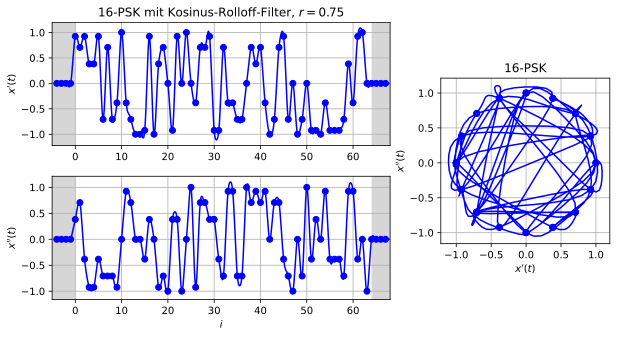

In [7]:
x_rc = np.convolve(x.flatten(),g_rc)

fig = plt.figure(figsize=(10,5))
spec = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])
subspec = spec[0].subgridspec(2, 1)
plt.subplots_adjust(hspace=0.25)

ax1 = fig.add_subplot(subspec[0])
ax1.plot(time, np.real(x_rc), 'b-o', markevery=w)
#plt.xlabel('$i$')
plt.ylabel('$x^\prime(t)$')
plt.title('%g-PSK mit Kosinus-Rolloff-Filter, $r=$%1.2f' %(M,r))
plt.grid(True)
plt.xlim(-N_rc_sym/2-1,N_symbols+N_rc_sym/2)
plt.axvspan(-N_rc_sym/2-1, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(N_symbols, N_symbols+N_rc_sym/2, facecolor='0.2', alpha=0.2)

ax2 = fig.add_subplot(subspec[1])
ax2.plot(time, np.imag(x_rc), 'b-o', markevery=w)
plt.xlabel('$i$')
plt.ylabel('$x^{\prime\prime}(t)$')
plt.grid(True)
plt.xlim(-N_rc_sym/2-1,N_symbols+N_rc_sym/2)
plt.axvspan(-N_rc_sym/2-1, 0, facecolor='0.2', alpha=0.2)
plt.axvspan(N_symbols, N_symbols+N_rc_sym/2, facecolor='0.2', alpha=0.2)

ax3 = fig.add_subplot(spec[1])
ax3.plot(np.real(x_rc[int(N_rc/2):len(x_rc)-int(N_rc/2)-w]), np.imag(x_rc[int(N_rc/2):len(x_rc)-int(N_rc/2)-w]), 'b-o', markevery=w)
ax3.set(adjustable='box', aspect='equal')
plt.xlabel('$x^\prime(t)$')
plt.ylabel('$x^{\prime\prime}(t)$')
plt.title('%g-PSK' %(M))
plt.grid(True)

Demgegenüber zeigen die obigen Bilder, dass bei einem Kosinus-Rolloff-Filter zu den idealen Abtastzeitpunkten die erwarteten Symbolwerte abzulesen sind und die 1. Nyquist-Bedingung erfüllt wird.

## Verschiebung in das Übertragungsband

Zur Verschiebung in das Übertragungsband ist das Basisbandsignal $x(t)$ mit der Trägerschwingung zu multiplizieren, $x(t)$ moduliert sozusagen die Trägerschwingung. Mathematisch erhalten wir

\begin{equation}
    x_{\mathrm{QAM}}(t) = \mathrm{Re} \{ x(t) \cdot e^{j \omega_0t} \} 
                        = x'(t) \cdot \cos(\omega_0t) - x''(t) \cdot \sin(\omega_0t) \; .
\end{equation}  

Das unten folgende Bild veranschaulicht das sich ergebende Zeitsignal. Um die hochfrequente Trägerschwingung mit $f_0=5$ MHz zu visualisieren, wurde die Überabtastung um den Faktor $w_2$ erhöht. Das blaue Zeitsignal wird durch die rot dargestellt Einhüllende nach oben und nach unten begrenzt.

(5.0, 25.0)

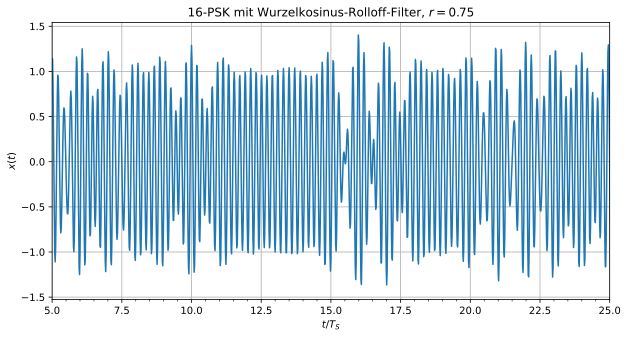

In [8]:
# carrier frequency in Hz
f0 = 5e6
# additional oversampling factor
w2 = 8
# sampling rate in Hz
fa2 = fa * w2
# length of filter impulse response in samples
N_rc2 = N_rc*w2
tmp,g_rrc2 = rrcosfilter(N_rc2,r,Ts,fa2)

# oversampling data symbols by inserting w zeros 
x2 = np.append(np.reshape(d_psk,(N_symbols,1)),np.zeros((N_symbols,w*w2-1)),axis=1)
x2 = np.reshape(x2,(N_symbols*w*w2,1))

x_rrc2 = np.convolve(np.real(x2).flatten(),g_rrc2) + 1j*np.convolve(np.imag(x2).flatten(),g_rrc2)
time2 = (np.arange(N_symbols*w*w2+N_rc2-1)-N_rc2/2) / w/w2
x_psk2 = np.real(x_rrc2) * np.cos(2 * np.pi * f0 * time2*Ts) - np.imag(x_rrc2) * np.sin(2 * np.pi * f0 * time2*Ts)

fig = plt.figure(figsize=(10,5))
from matplotlib.ticker import AutoMinorLocator
ax = fig.add_subplot(111)
ax.plot(time2,x_psk2)
plt.xlabel('$t/T_S$')
plt.ylabel('$x(t)$')
plt.title('%g-PSK mit Wurzelkosinus-Rolloff-Filter, $r=$%1.2f' %(M,r))
plt.grid(True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
#plt.yticks(sqrt_ask)
plt.xlim(5,25)

## Leistungsdichtespektrum

Da das modulierte Signal ein stochastisches Signal ist, kann nicht einfach die Fourier-Transformierte zur Bestimmung des Spektrums berechnet werden. Vielmehr wird das Leistungdichtespektrum verwendet, das die mittlere Verteilung der Leistung über der Frequenz angibt. Es berechnet sich nach dem Theorem von Wiener und Khintchine aus der Fourier-Transformierten der Autokorrelationsfunktion. Für mittelwertfreie, identisch verteilte und statistisch unabhängige Datensymbole (i.i.d.) lautet die spektrale Leistungsdichte

\begin{equation}
    \Phi_{{\cal XX}}(j \omega) = \sigma_D^2 \cdot T_S \cdot |G_S(j \omega)|^2
\end{equation}

Es hängt also bis auf eine Skalierung mit $\sigma_D^2 \cdot T_S$ nur vom Betragsquadrat der Übertragungsfunktion des Sendefilters ab.

Für eine akzeptable Auflösung im Frequenzbereich benötigen wir deutlich längere Sequenzen. Im folgenden Code-Segment wird daher ein längeres PSK-Signal erzeugt und dann das Leistungsdichtespektrum mit Hilfe der Welch-Methode geschätzt. 

In [9]:
from scipy import signal

# number of QAM symbols
N = 1000

# averaging for power density spectrum
Npsd = 10

# extract tuples of m bits
u_b = np.reshape(np.random.randint(0,2,N*m),(N,m))
d_a = np.zeros(N,dtype=complex)

for run in np.arange(N):
    # mapping of bit tuples on decimal numbers 
    u_d = bin2int(u_b[run,:].tolist())
    # mapping index to Gray coded index to PSK symbols
    d_a[run] = psk[gray_code[int(u_d)]]
    
# upsampling and convolution with impulse response of RRC filter    
x = np.append(np.reshape(d_a,(N,1)),np.zeros((N,w-1)),axis=1)
x = np.reshape(x,(N*w,1))

x_r = np.convolve(np.real(x).flatten(),g_rrc)+1j*np.convolve(np.imag(x).flatten(),g_rrc)
time = (np.arange(N*w+N_rc-1)-N_rc/2) / w  


# estimation of power spectral density with Welch method
f, psd = signal.welch(x_r, fs=fa, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)

# rearrange positive and negative frequencies
f = np.fft.fftshift(f)
psd = np.fft.fftshift(psd) * N_rc

# analytical solution of power spectral density equals squared magnitude of transfer function of root-raised-cosine transmit filter
# squared magnitude of root-raised-cosine characteristic equals raised-cosine characteristic
# solution normalized to maximum value of 1 (divided by T_s sigma_D^2)
G_RC = 0.5 * (1 + np.cos(np.pi/(2*r)*(np.abs(f)*2*Ts-(1-r))))
ptr = np.argwhere(np.abs(f)*2*Ts<1-r)
G_RC[ptr.flatten()] = 1.0
ptr = np.argwhere(np.abs(f)*2*Ts>1+r)
G_RC[ptr.flatten()] = 0.0

(-2.0, 2.0, 1e-06, 2.0)

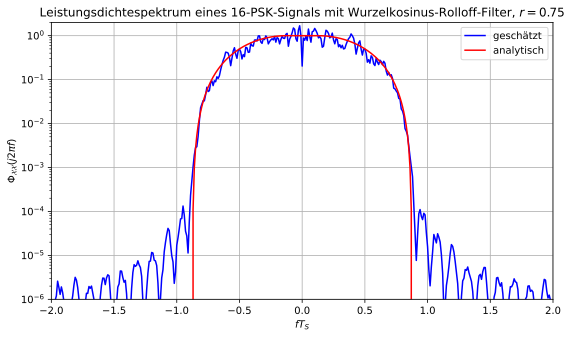

In [10]:
fig_psd = plt.figure(figsize=(9,5))
ax = fig_psd.add_subplot(111)
ax.semilogy(f*Ts, psd,'b-',label='geschätzt')
ax.semilogy(f*Ts, G_RC,'r-',label='analytisch')
plt.title('Leistungsdichtespektrum eines %g-PSK-Signals mit Wurzelkosinus-Rolloff-Filter, $r=$%1.2f' %(M,r))
plt.xlabel('$f T_S$')
plt.ylabel('$\Phi_{\cal XX}(j 2 \pi f)$')
plt.legend()
plt.grid(True)
plt.axis([-2, 2, 1e-6, 2.0])

Dem obigen Bild ist zu entnehmen, dass die analytische Berechnung gut mit dem geschätzten Leistungsdichtespektrum übereinstimmt. Es ist auch zu erkennen, dass für den Rolloff-Faktor $r=0.75$ die Bandbreite $B_{NF} = (1+r) \cdot f_N = \frac{1.75}{2 T_S} = 0.875$ MHz beträgt. Die Rippel des geschätzten Spektrum resultieren aus der zeitlichen Begrenzung der Impulsantwort $g_{\mathrm{RRC}}(t)$ des Sendefilters. Letzteres entspricht einer Multiplikation mit einem Rechteck, was im Frequenzbereich zu einer Faltung mit der zugehörigen si-Funktion wird. Außerdem sorgen die endliche Datenmenge und die Fensterung mit dem Hanning-Fenster nach dem Welch-Ansatz für leichte Ungenauigkeiten. 

(-4.0, 4.0, 1e-06, 2.0)

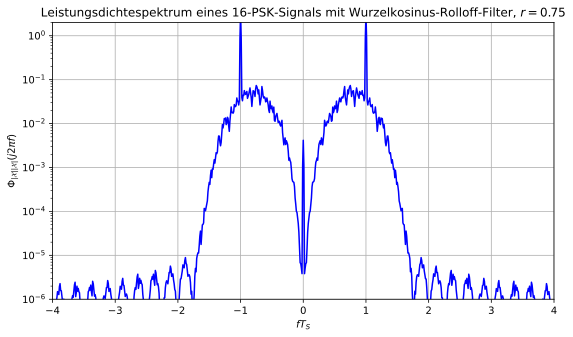

In [12]:
# estimation of power spectral density with Welch method
f_mag2, psd_mag2 = signal.welch(np.abs(x_r)**2, fs=fa, nperseg=N*w/Npsd, return_onesided=False, scaling='spectrum',axis=0)

# rearrange positive and negative frequencies
f_mag2 = np.fft.fftshift(f_mag2)
psd_mag2 = np.fft.fftshift(psd_mag2) * N_rc

fig_psd_mag2 = plt.figure(figsize=(9,5))
ax = fig_psd_mag2.add_subplot(111)
ax.semilogy(f_mag2*Ts, psd_mag2,'b-',label='geschätzt')
plt.title('Leistungsdichtespektrum eines %g-PSK-Signals mit Wurzelkosinus-Rolloff-Filter, $r=$%1.2f' %(M,r))
plt.xlabel('$f T_S$')
plt.ylabel('$\Phi_{|{\cal X}||{\cal X}|}(j 2 \pi f)$')
#plt.legend()
plt.grid(True)
plt.axis([-4, 4, 1e-6, 2.0])